# ResNet Architecture without fine-tuning



In [1]:
import kagglehub

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)


100%|██████████| 149M/149M [00:01<00:00, 94.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


In [2]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1"
print("Contents of dataset folder:", os.listdir(dataset_path))


Contents of dataset folder: ['Training', 'Testing']


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torchvision.models as models
import os
from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


torch.backends.cudnn.benchmark = True


train_dataset_path = "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training"
test_dataset_path = "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing"


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ["glioma", "meningioma", "notumor", "pituitary"]
        self.image_paths = []
        self.labels = []

        
        for idx, tumor_class in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, tumor_class)
            if not os.path.exists(class_dir):
                print(f"Warning: {class_dir} does not exist")
                continue
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):  
                    self.image_paths.append(img_path)
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


train_dataset = BrainTumorDataset(root_dir=train_dataset_path, transform=transform)
test_dataset = BrainTumorDataset(root_dir=test_dataset_path, transform=transform)


train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

print(f"Training samples: {train_size}, Validation samples: {val_size}, Testing samples: {len(test_dataset)}")


model = models.resnet50(pretrained=True)


num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)


model = model.to(device)


criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")


torch.save(model.state_dict(), "brain_tumor_resnet50.pth")
print("Training complete! Model saved.")


model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

val_accuracy = 100 * correct / total
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Using device: cuda
Training samples: 4569, Validation samples: 1143, Testing samples: 1311
Epoch 1, Loss: 0.4835, Train Accuracy: 81.97%
Epoch 2, Loss: 0.2583, Train Accuracy: 91.16%
Epoch 3, Loss: 0.1864, Train Accuracy: 93.35%
Epoch 4, Loss: 0.1696, Train Accuracy: 93.89%
Epoch 5, Loss: 0.1298, Train Accuracy: 95.62%
Training complete! Model saved.
Validation Accuracy: 92.56%


In [ ]:

model.load_state_dict(torch.load("brain_tumor_resnet50.pth"))
model.to(device)
model.eval() 

correct = 0
total = 0

with torch.no_grad():  
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


<ipython-input-5-d8182082e702>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("brain_tumor_resnet50.pth"))


Test Accuracy: 92.83%


# Evaluation Parameters


In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


model.load_state_dict(torch.load("brain_tumor_resnet50.pth", map_location=device))
model.to(device)
model.eval()  


all_labels = []
all_predictions = []

with torch.no_grad():  
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1) 

        all_labels.extend(labels.cpu().numpy())  
        all_predictions.extend(predicted.cpu().numpy())


all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)


test_accuracy = accuracy_score(all_labels, all_predictions) * 100
test_precision = precision_score(all_labels, all_predictions, average='macro') * 100
test_recall = recall_score(all_labels, all_predictions, average='macro') * 100
test_f1 = f1_score(all_labels, all_predictions, average='macro') * 100
conf_matrix = confusion_matrix(all_labels, all_predictions)


print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Precision: {test_precision:.2f}%")
print(f"Recall: {test_recall:.2f}%")
print(f"F1 Score: {test_f1:.2f}%")
print("Confusion Matrix:")
print(conf_matrix)


<ipython-input-7-6d1b89b1d29d>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("brain_tumor_resnet50.pth", map_location=device))


Test Accuracy: 92.83%
Precision: 92.95%
Recall: 92.57%
F1 Score: 92.74%
Confusion Matrix:
[[275  18   7   0]
 [ 11 269  19   7]
 [  0  16 389   0]
 [  6   4   6 284]]


# Grad-CAM

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-15-d4bba4a43cd8>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

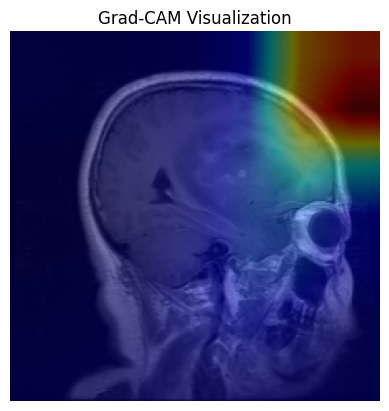

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 4)
model.load_state_dict(torch.load("brain_tumor_resnet50.pth", map_location=device))
model.eval().to(device)


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradient = None
        self.activation = None

        self.target_layer.register_forward_hook(self.forward_hook)

    def forward_hook(self, module, input, output):
        self.activation = output
        output.register_hook(self.backward_hook)

    def backward_hook(self, grad):
        self.gradient = grad

    def generate_heatmap(self, image, class_idx):
        self.model.zero_grad()
        output = self.model(image)
        score = output[:, class_idx]
        score.backward()

        weights = self.gradient.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activation).sum(dim=1, keepdim=True)
        cam = F.relu(cam).squeeze().detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min()) 
        return cam

def apply_heatmap(image_path, heatmap):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    heatmap = cv2.resize(heatmap, (224, 224))

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


sample_image_path = "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/glioma/Te-gl_0270.jpg"
image = Image.open(sample_image_path).convert("RGB")
image = transform(image).unsqueeze(0).to(device)


target_layer = model.layer4[2].conv3  
grad_cam = GradCAM(model, target_layer)


class_idx = torch.argmax(model(image)).item()


heatmap = grad_cam.generate_heatmap(image, class_idx)


result_img = apply_heatmap(sample_image_path, heatmap)


result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)


plt.imshow(result_img_rgb)
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()


In [ ]:
from PIL import Image


sample_image_path = "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing/glioma/Te-gl_0270.jpg"

try:
    image = Image.open(sample_image_path)
    image.show()  
    print("Image loaded successfully!")
except FileNotFoundError:
    print("Error: Image not found.")
except Exception as e:
    print(f"Unexpected error: {e}")


Image loaded successfully!
